In [1]:
# Required to set up the virtual environment if you want to access files stored on google drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading required packages and libraries.
import PIL
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights

# Importing glob and os to read all images in the folder.
import glob
import os

## Loading the pretrained model

We choose SqueezeNet, as it is lightweight and runs fast on CPUs. Additionally, we explicitly choose the pretrained weights SqueezeNet1_1_Weights.IMAGENET1K_V1 so that the results are reproducible.

In [3]:
# Check if GPU is available, and set the device.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('Using', device)

# Download and load the pretrained SqueezeNet model.
model = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1).to(device)

# Disable the gradient computation with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

Using cpu


## Writing some often-used functions

If this was being written as a library, I would put these functions in utils.py.

In [4]:
# Writing preprocessing and deprocessing functions for ImageNet inputs.

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def preprocess(img, size=(224, 224)):
  """
  Preprocesses an input image to meet ImageNet specifications.
  The output of this function can be used as input to a model trained on ImageNet.

  Inputs:
  - img: the input image.

  Returns:
  - preprocessed_img: the preprocessed image (as a torch tensor).
  """

  transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN.tolist(),
                    std=IMAGENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
  preprocessed_img = transform(img)
  return preprocessed_img

def deprocess(img):
  """
  Deprocesses the output of a pretrained classifier trained on ImageNet.
  This reverses the preprocessing done on an image to make it a compatible input to classifiers trained on ImageNet.

  Inputs:
  - img: the input image (as a torch tensor).

  Returns:
  - deprocessed_img: the deprocessed image.
  """
  transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / IMAGENET_STD).tolist()),
        T.Normalize(mean=(-IMAGENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
  deprocessed_img = transform(img)
  return deprocessed_img

In [5]:
def idx_to_label(idx):

  """
  This function converts the class index to the corresponding class label for ImageNet.

  Inputs:
  - idx: index of a given class (should be a non-negative integer less than 1000).

  Returns:
  - class_label: class label (string) associated with the given class index.
  """

  # Can add tests and checks here to ensure that idx is an integer in the range [0,1000).

  weights = SqueezeNet1_1_Weights.IMAGENET1K_V1
  class_label = weights.meta["categories"][idx]

  return class_label

In [6]:
def plot_image(img, title="Image"):
  """
  Function to plot a given image.

  Inputs:
  - img: the image to be plotted.
  - title: the title to be used to describe the image.
  """
  plt.figure(figsize=(4,4))
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

## The function which generates adversarial inputs

In [7]:
def make_adversarial_attack(X, target_y, model=model):
    """
    Generate an image that is close to X but is altered with adversarial noise such that the model classifies it as target_y.

    Inputs:
    - X: input image; tensor of shape (1, 3, 224, 224).
    - target_y: an integer in the range [0, 1000).
    - model: a pretrained DNN; SqueezeNet is used as the default model.

    Returns:
    - X_adversarial: An image that is close to X, but it is classifed as target_y by the model.
    """

    # Using the pretrained model in eval mode.
    model.eval()

    # Initializing the adversarial image with the input image.
    X_adversarial = X.clone().detach()
    X_adversarial.requires_grad = True

    # Setting the learning rate.
    learning_rate = 1

    # Setting maximum number of iterations.
    max_iter = 500

    # Loop for gradient ascent.
    for i in range(max_iter):

        # Getting the score.
        score = model(X_adversarial)
        # Breaking from the loop if we predict the target class.
        _, index = score.data.max(dim=1)
        if index[0] == target_y:
            break

        # Score for target class.
        score_target = score[0, target_y]
        score_target.backward()

        # Gradient of the image.
        dx = X_adversarial.grad.data
        # Normalizing the gradient.
        dx = learning_rate * (dx / torch.norm(dx))
        # Updating the image.
        X_adversarial.data += dx
        X_adversarial.grad.zero_()

    X_adversarial = X_adversarial.detach()

    return X_adversarial

## Testing the code

If this was being written as a library, we could potentially write this block of code as a function, with filepath and target_y as the arguments. We could accept the filepath and target_y from the user, and perhaps provide support for having different target classes for different inputs.

In [8]:
# Define the filepath of the image(s). Change this to wherever the test images are stored.
filepath = "/content/drive/My Drive/code_tests/leap_labs/test_data/"

# Defining the target class.
target_y = 500
print("Target class index is: {0}".format(target_y))
print("Target class label is: {0}\n".format(idx_to_label(target_y)))

# Initializing lists to store the original images and the corresponding adversarial images.
# This is done to support having multiple input images, but in this script we use only one input.
X_saved = []
X_adversarial_saved = []

# Reading the files and generating the adversarial images.
for filename in glob.glob(filepath + '/*.png'):

    # Loading the image.
    image = PIL.Image.open(filename)
    # Extracting filename, because the images are assumed to be saved with their true class index.
    true_y = os.path.basename(filename)
    # Removing .png extension from filename.
    true_y = os.path.splitext(true_y)[0]
    # Converting the string into an integer.
    true_y = int(true_y)
    print("True class index is: {0}".format(true_y))
    print("True class label is: {0}\n".format(idx_to_label(true_y)))

    # Setting target label.
    target_y = target_y

    # Using the preprocess function.
    X = preprocess(image)
    X_saved.append(X)
    # Using the make_adversarial_attack function.
    X_adversarial = make_adversarial_attack(X, target_y, model)
    X_adversarial_saved.append(X_adversarial)

    # Confirming that the image will be misclassified as the target class.
    scores = model(X_adversarial)
    predicted_class = scores.data.max(1)[1][0]
    print("New predicted class index is: {0}".format(predicted_class))
    print("New predicted class label is: {0}\n".format(idx_to_label(predicted_class)))

Target class index is: 500
Target class label is: cliff dwelling

True class index is: 366
True class label is: gorilla

New predicted class index is: 500
New predicted class label is: cliff dwelling



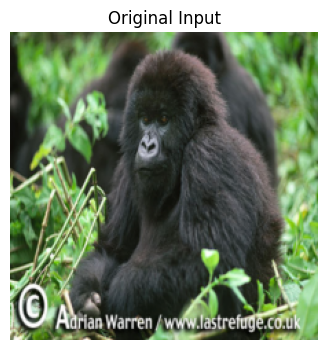

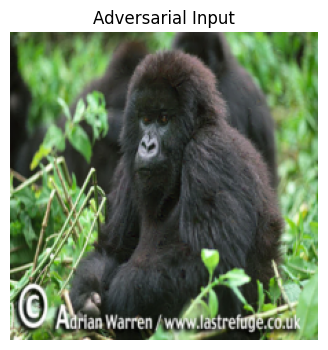

In [9]:
# Visualizing the outputs.

for i in range(len(X_saved)):

  # Plotting the original input image.
  plot_image(deprocess(X_saved[i]), title="Original Input")

  # Plotting the adversarial input image.
  plot_image(deprocess(X_adversarial_saved[i]), title="Adversarial Input")